# ASSIGNMENT

In this notebook, using the **Seattle Bicycle Weather** dataset, I will make these visualizations:

- Feature Importances
- Permutation Importances
- Partial Dependence Plot
- Shapley Values

In [12]:
# Import libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

## Prepare Data and Initial Model



In [2]:
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily


In [3]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [6]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)
    
    #snow and snwd is in 1/10 mm; convert to inches
    X['SNOW'] /= 254
    X['SNWD'] /= 254
    
    #create interaction terms
    X['PRCP_TMXAX'] = X['PRCP'] * X['TMAX']
    X['PRCP_TMIN'] = X['PRCP'] * X['TMIN']
    X['PRCP_Temp_(C)'] = X['PRCP'] * X ['Temp (C)']
    

    return X


In [7]:
data = load()

In [90]:
# load and wrangle

df = wrangle(data)
X_train, X_test, y_train, y_test = split(df)

In [77]:
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1,5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions = param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0893s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.3s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f42795f7710>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4279ea7c88>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [78]:
print('Mean Absolute Error with CV ')
print(f'Predictions are off by {-search.best_score_} bicyclists per day, on average')

best = search.best_estimator_

y_pred = best.predict(X_test.values)
print(f'Test Predictions are off by {mean_absolute_error(y_test, y_pred)} bicyclists per day, on average')

Mean Absolute Error with CV 
Predictions are off by 265.8202038306437 bicyclists per day, on average
Test Predictions are off by 229.39616943359374 bicyclists per day, on average


## Feature Importances

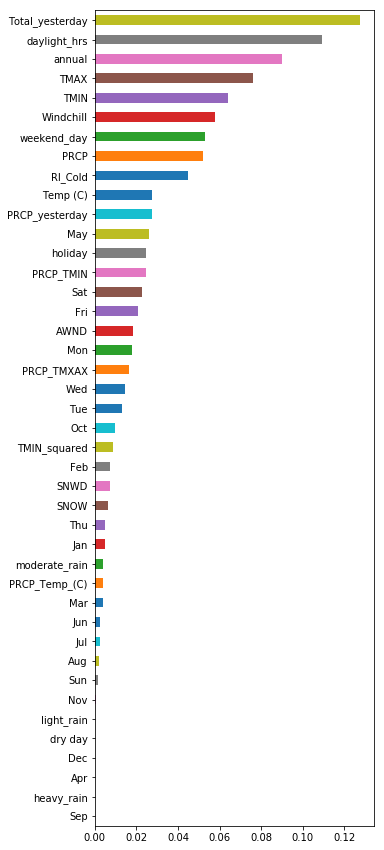

In [79]:
# this plots our models default importances 
n = len(X_train.columns)

size= (5,15)

importances = pd.Series(best.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]

plt.figure(figsize=size)
top_n.plot.barh();

## Permutation Importances


In [83]:
import eli5
from eli5.sklearn import PermutationImportance

In [84]:
permuter = PermutationImportance(best, scoring='neg_mean_absolute_error', cv='prefit',
                                n_iter=10, random_state=42)
permuter.fit(X_test, y_test)

PermutationImportance(cv='prefit',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=495,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
           n_iter=10, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [69]:
feature_names = X_test.columns.tolist()

eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
544.5336 ± 25.9499,TMAX
508.7985 ± 26.8436,weekend_day
144.4681 ± 7.6209,Total_yesterday
121.8842 ± 11.6525,PRCP
62.7130 ± 7.0515,TMIN
42.7934 ± 6.3765,Fri
40.0098 ± 7.4895,May
31.2966 ± 5.7336,holiday
23.1814 ± 6.9168,PRCP_TMIN
22.3693 ± 2.1008,Rl_Cold


In [85]:
# we'll use this for feature selection
print('Shape before removing features:', X_train.shape)

Shape before removing features: (963, 42)


In [91]:
mask = permuter.feature_importances_ > 0

important_features = X_train.columns[mask]

X_train = X_train[important_features]
X_test = X_test[important_features]


print('Shape after removing features: ', X_train.shape)

Shape after removing features:  (963, 23)


In [92]:
param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1,5)
}

search = RandomizedSearchCV(
    estimator=XGBRegressor(n_jobs=-1, random_state=42),
    param_distributions = param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=3,
    verbose=10,
    return_train_score=True,
    random_state=42
)

search.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1289s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.4s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4278e68e48>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4279fc7c18>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [93]:
print('Mean Absolute Error with CV on only important features')
print(f'Predictions are off by {-search.best_score_} bicyclists per day, on average')

best = search.best_estimator_

y_pred = best.predict(X_test.values)

print(f'Test Predictions are off by {mean_absolute_error(y_test, y_pred)} bicyclists per day, on average')

Mean Absolute Error with CV on only important features
Predictions are off by 270.5941130993646 bicyclists per day, on average
Test Predictions are off by 269.43383239746095 bicyclists per day, on average


Well this did not improve our score it seems. :)

## Partial Dependence Plot

In [99]:
assert(X_test.columns == X_train.columns).all()

In [96]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Total_yesterday'

isolated = pdp_isolate(
    model = best,
    dataset = X_test,
    model_features = X_test.columns,
    feature = feature
)

pdp_plot(isolated, feature_name = feature);

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22'] ['PRCP', 'TMAX', 'TMIN', 'Total_yesterday', 'Mon', 'Tue', 'Wed', 'Fri', 'Sat', 'holiday', 'daylight_hrs', 'Temp (C)', 'PRCP_yesterday', 'Windchill', 'Rl_Cold', 'May', 'Jun', 'Jul', 'Aug', 'weekend_day', 'PRCP_TMXAX', 'PRCP_TMIN', 'PRCP_Temp_(C)']
expected f7, f18, f16, f8, f4, f2, f14, f6, f5, f15, f13, f1, f9, f21, f11, f20, f19, f22, f10, f0, f17, f3, f12 in input data
training data did not have the following fields: Jul, PRCP_TMIN, PRCP_Temp_(C), PRCP_TMXAX, Mon, Wed, Windchill, PRCP_yesterday, weekend_day, Fri, Rl_Cold, Tue, Sat, daylight_hrs, May, Jun, Total_yesterday, Aug, TMIN, holiday, Temp (C), PRCP, TMAX

In [55]:
from pdpbox.pdp import pdp_interact, pdp_isolate, pdp_plot, pdp_interact_plot

feature = 'PRCP'

isolated = pdp_isolate(
    model=best,
    dataset=X_test,
    model_features=X_test.columns,
    feature = feature
)

pdp_plot(isolated, feature_name=feature)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18'] ['PRCP', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'Tue', 'Wed', 'Fri', 'Sat', 'holiday', 'Temp (C)', 'PRCP_yesterday', 'Windchill', 'Rl_Cold', 'May', 'weekend_day', 'PRCP_TMXAX', 'PRCP_TMIN', 'PRCP_Temp_(C)']
expected f7, f18, f16, f8, f4, f2, f14, f6, f5, f15, f13, f1, f9, f11, f10, f0, f17, f3, f12 in input data
training data did not have the following fields: PRCP_TMIN, PRCP_Temp_(C), PRCP_TMXAX, Wed, Windchill, PRCP_yesterday, weekend_day, Fri, Rl_Cold, Tue, Sat, May, Total_yesterday, TMIN, AWND, holiday, Temp (C), PRCP, TMAX

In [ ]:
features = ['Total_yesterday', 'TMAX']

interaction = pdp_interact(
    model=best,
    dataset=X_test,
    model_features=X_.columns.tolist(),
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);


- Shapley Values